# Model Prediction and Data Visualization using OpenFace

This is a demonstration of how to use two models to evaluate the engagement level of a person from the zoom recording.  
The first model uses the strength of 17 action units, the second model uses head pose, eye gaze and face shape change as the input feature vectors.  
The models were trained by random forest regressor.  
The video used here was cropped from a zoom meeting.  
For demonstration purpose only.

## Importing

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import cv2
%matplotlib inline  

### Load video and the OpenFace output file (facial attributes, action units)

In [2]:
# data_OpenFace: OpenFace output, .csv
# video: video processed by OpenFace to show facial landmarks, head pose and eye gaze.
data_OpenFace = "adam/adam.csv"
video = "adam/adam.avi"

**OpenFace processed video file**:
- Red dots: facial landmarks
- Blue box: head pose
- light blue lines from the eyes: eye gaze

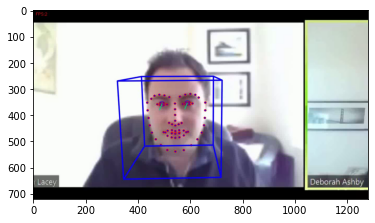

In [3]:
cap = cv2.VideoCapture(video)
_,frame = cap.read()
if frame is not None:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

## **Input data: OpenFace processed data**.   
The data file contains:  
**1.Basic**  
    * **frame** the number of the frame (in case of sequences)  
    * **face_id** the face id (in case of multiple faces), there is no guarantee that this is consistent across frames in case of FaceLandmarkVidMulti, especially in longer sequences  
    * **timestamp** the timer of video being processed in seconds (in case of sequences)  
    * **confidence** how confident is the tracker in current landmark detection estimage  
    * **success** is the track successful (is there a face in the frame or do we think we tracked it well)  
      
**2.Gaze related**  
    * **Eye gaze direction vector** gaze_0_x, gaze_0_y, gaze_0_z, ...  
    * **Eye gaze direction in radians** gaze_angle_x, gaze_angle_y,...  
    * **Location of 2D eye region landmarks** eye_lmk_x_0, eye_lmk_x_1,...  
      
**3.Head Pose**  
    * **Location of the head with respect to camera** pose_Tx, pose_Ty, pose_Tz  
    * **Rotation is in radians around X,Y,Z axes** pose_Rx, pose_Ry, pose_Rz  
    * **Location of 2D eye region landmarks** eye_lmk_x_0, eye_lmk_x_1,...  
      
**4.Landmarks locations**  
    * **2D** x_0, x_1, ... x_66, x_67, y_0,...y_67  
    * **3D** X_0, ... X_67, Y_0,...Y_67, Z_0,...Z_67 
      
**5.shape parameters**  
Parameters of a point distribution model (PDM) that describe the rigid face shape (location, scale and rotation) and non-rigid face shape (deformation due to expression and identity)  
    * **2D** x_0, x_1, ... x_66, x_67, y_0,...y_67  
    * **3D** X_0, ... X_67, Y_0,...Y_67, Z_0,...Z_67 
      
**6.Facial Action Units**  
Fundamental actions of individual facial muscles or groups of facial muscles.  
    * **intensity(0-5)** AU01_r, AU02_r, AU04_r, AU05_r, AU06_r, AU07_r, AU09_r, AU10_r, AU12_r, AU14_r, AU15_r, AU17_r, AU20_r, AU23_r, AU25_r, AU26_r, AU45_r  
    * **presense** AU01_c, AU02_c, AU04_c, AU05_c, AU06_c, AU07_c, AU09_c, AU10_c, AU12_c, AU14_c, AU15_c, AU17_c, AU20_c, AU23_c, AU25_c, AU26_c, AU28_c, AU45_c




In [4]:
# read .csv data file
openface_feat = pd.read_csv(data_OpenFace, delimiter=',',engine='python',\
        skipinitialspace=True).fillna(0)
openface_feat.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.058216,0.262397,-0.963202,-0.043985,0.257788,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.033,0.98,1,0.051868,0.257272,-0.964946,-0.037686,0.245067,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.067,0.98,1,0.051941,0.177871,-0.982682,-0.032860,0.241509,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.100,0.98,1,0.049238,0.180367,-0.982366,-0.044367,0.228608,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.133,0.98,1,0.047199,0.187337,-0.981161,-0.039805,0.232864,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Model:  
* Model 1: Action Units
* Model 2: head pose + eye gaze + non-rigid face shape

In [5]:
MODEL_AU_NAME = "model_FAU.sav"
MODEL_FA_NAME = "model_FA.sav"
au_model = joblib.load(MODEL_AU_NAME)
face_model = joblib.load(MODEL_FA_NAME)

### Specify what features to be used in prediction  
Two types of inputs are used here.  
One is Action Units, the other one include: head pose + eye gaze + non-rigid face shape

In [6]:
# AUs (intensity), model 1
OPENFACE_MODALITY_AU = AU_INTENSITY_HEADER = ["AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU07_r", "AU09_r",
                       "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU23_r",
                       "AU25_r", "AU26_r", "AU45_r"]

# Facial attributes: head pose + eye gaze + non-rigid face shape
# model 2
PDM_HEADER_NONRIGID = ["p_0", "p_1", "p_2", "p_3", "p_4", "p_5", "p_6", "p_7", "p_8",
                       "p_9", "p_10", "p_11", "p_12", "p_13", "p_14", "p_15", "p_16",
                       "p_17", "p_18", "p_19", "p_20", "p_21", "p_22", "p_23", "p_24",
                       "p_25", "p_26", "p_27", "p_28", "p_29", "p_30", "p_31", "p_32", "p_33"]
GAZE_HEADER = ["gaze_0_x", "gaze_0_y", "gaze_0_z",
               "gaze_1_x", "gaze_1_y", "gaze_1_z"]
HEAD_POSE_HEADER = ["pose_Tx", "pose_Ty",
                    "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz"]
OPENFACE_MODALITY_FACE = PDM_HEADER_NONRIGID + GAZE_HEADER + HEAD_POSE_HEADER

In [7]:
# get the mean and standard deviation of the features
def get_moment_param(segmented_features):
    """Returns mean and std."""
    feat_mean = np.mean(segmented_features, axis=1)
    feat_std = np.std(segmented_features, axis=1)
    return np.concatenate((feat_mean, feat_std), axis=1)

## Engagement evaluation

In [8]:
# the time range engagement analysis is performed on. Must not exceeds the length of the video (s)
t_start, t_end = 20, 180
# window size and sliding length (s)
t_window, t_slide = 5, 2

# Model 1, predicted with AUs
arr_pred_au = []
for i in range(t_start,t_end,t_slide):
    filtered_feat = openface_feat[
    (openface_feat["timestamp"] > i) &
    (openface_feat["timestamp"] < i+t_window) &
    (openface_feat["success"] == 1)
    ]

    selected_openface_feat = filtered_feat[OPENFACE_MODALITY_AU]
    selected_openface_feat = selected_openface_feat.to_numpy()
    final_feat = get_moment_param([selected_openface_feat])
    pred_au = au_model.predict(final_feat)
    arr_pred_au.append(pred_au)
    
    
# Model 2, predicted with facial attributes
arr_pred_fa = []
for i in range(t_start,t_end,t_slide):
    filtered_feat = openface_feat[
    (openface_feat["timestamp"] > i) &
    (openface_feat["timestamp"] < i+t_window) &
    (openface_feat["success"] == 1)
    ]

    selected_openface_feat = filtered_feat[OPENFACE_MODALITY_FACE]
    selected_openface_feat = selected_openface_feat.to_numpy()
    final_feat = get_moment_param([selected_openface_feat])
    pred_face = face_model.predict(final_feat)
    arr_pred_fa.append(pred_face)
    

### Plot the engagement evaluation by two models.

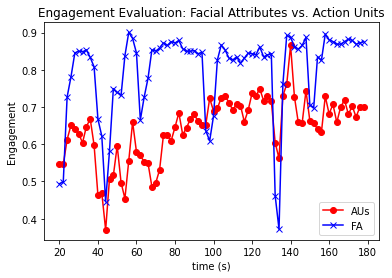

In [9]:
fig, ax = plt.subplots()
plt.plot(list(range(t_start,t_end,t_slide)),arr_pred_au,color='red', marker='o',label = 'AUs')
plt.plot(list(range(t_start,t_end,t_slide)),arr_pred_fa,color='blue', marker='x',label = 'FA')
plt.legend()
ax.set(xlabel='time (s)', ylabel='Engagement',
       title='Engagement Evaluation: Facial Attributes vs. Action Units')
plt.show()

### Reference:  
* https://github.com/Shivam1904/Emotiw2020_Engagement_Prediction
* https://www.youtube.com/watch?v=U_JohBDMur4&ab_channel=SimonSezIT